In [1]:
import cv2
import os
import shutil
import torch,torchvision
import math
import pandas
import natsort
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
import numpy as np
from PIL import Image, ImageFilter
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/BinarySplit"

In [ ]:
def load_data(path, test_split, val_split, batch_size, input_size, k_folds):

    transform_dict={'src':transforms.Compose([
                      transforms.RandomHorizontalFlip(),
                      transforms.Resize((224,224)),
                      transforms.RandomVerticalFlip(),
                      transforms.RandomRotation(15),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
    )}

    dataset = datasets.ImageFolder(root=path, transform=transform_dict['src'])
    kfold = StratifiedKFold(n_splits=k_folds)
    train_loader = []
    val_loaders = []
    test_loader = []
    for train_idx, test_idx in kfold.split(dataset, dataset.targets):
        train_dataset = torch.utils.data.Subset(dataset, train_idx)
        test_dataset = torch.utils.data.Subset(dataset, test_idx)
        val_size = int(len(train_dataset) * val_split)
        train_size = len(train_dataset) - val_size
        train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
        train_loader.append(train_loader)
        test_loader.append(test_loader)
        val_loaders.append(val_loader)
    return train_loader, val_loaders, test_loader

In [ ]:
train_loader, test_loader, val_loaders = load_data(path=path,
                                                     test_split=0.1,
                                                     val_split=0.1,
                                                     batch_size=32,
                                                     input_size=[200,200], k_folds=5
                                                    )

In [ ]:
number_epochs = 50
k_folds = 5
training_accuracy= []
val_accs = []
train_losses = []
val_losses = []
for fold in range(k_folds):
    print(f'Fold {fold + 1}')
    train_loader = train_loader[fold]
    val_loader = val_loaders[fold]
    test_loader = test_loader[fold]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torchvision.models.shufflenet_v2_x1_0(pretrained=False, num_classes=2)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    val_losses_fold = []
    train_losses_fold = []
    train_accs_fold = []
    val_accs_fold = []
    for epoch in range(number_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_accs_fold.append(train_acc)
        train_losses_fold.append(train_loss)
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            val_loss = 0.0
            for images, labels in val_loader:
                labels = labels.to(device)
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_loss /= len(val_loader.dataset)
            val_acc = 100 * correct / total
            val_losses_fold.append(val_loss)
            val_accs_fold.append(val_acc)
            print(f'Fold {fold + 1}, Epoch {epoch + 1}/{number_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    train_losses.append(train_losses_fold)
    train_accs.append(train_accs_fold)
    val_losses.append(val_losses_fold)
    val_accs.append(val_accs_fold)
avg_train_loss = [sum(train_losses[i])/len(train_losses[i]) for i in range(number_epochs)]
avg_train_acc = [sum(train_accs[i])/len(train_accs[i]) for i in range(number_epochs)]
avg_val_loss = [sum(val_losses[i])/len(val_losses[i]) for i in range(number_epochs)]


Fold 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Fold 1, Epoch 1/50, Training Loss: 0.7808, Training Accuracy: 58.00%, Validation Loss: 0.0428, Validation Accuracy: 71.70%
Fold 1, Epoch 2/50, Training Loss: 0.6663, Training Accuracy: 60.25%, Validation Loss: 0.0417, Validation Accuracy: 69.81%
Fold 1, Epoch 3/50, Training Loss: 0.6470, Training Accuracy: 62.92%, Validation Loss: 0.0408, Validation Accuracy: 72.17%
Fold 1, Epoch 4/50, Training Loss: 0.6368, Training Accuracy: 62.03%, Validation Loss: 0.0380, Validation Accuracy: 72.64%
Fold 1, Epoch 5/50, Training Loss: 0.6138, Training Accuracy: 66.16%, Validation Loss: 0.0400, Validation Accuracy: 73.58%
Fold 1, Epoch 6/50, Training Loss: 0.5758, Training Accuracy: 69.25%, Validation Loss: 0.0333, Validation Accuracy: 79.25%
Fold 1, Epoch 7/50, Training Loss: 0.5709, Training Accuracy: 71.29%, Validation Loss: 0.0368, Validation Accuracy: 72.17%
Fold 1, Epoch 8/50, Training Loss: 0.5533, Training Accuracy: 72.38%, Validation Loss: 0.0305, Validation Accuracy: 78.30%
Fold 1, Epoch 9/

IndexError: ignored

In [ ]:
training_accuracy

[[58.00209205020921,
  60.2510460251046,
  62.91841004184101,
  62.02928870292887,
  66.16108786610879,
  69.24686192468619,
  71.2866108786611,
  72.38493723849372,
  71.96652719665272,
  74.00627615062761,
  74.11087866108787,
  75.10460251046025,
  75.99372384937239,
  75.99372384937239,
  77.6673640167364,
  77.35355648535565,
  77.19665271966527,
  79.13179916317992,
  79.39330543933055,
  78.0857740585774,
  78.50418410041841,
  79.75941422594143,
  78.60878661087867,
  79.60251046025104,
  80.3347280334728,
  78.8702928870293,
  80.3347280334728,
  79.75941422594143,
  78.55648535564853,
  79.39330543933055,
  78.8702928870293,
  80.38702928870293,
  80.70083682008368,
  80.07322175732217,
  81.01464435146444,
  80.1255230125523,
  81.06694560669456,
  80.23012552301255,
  80.70083682008368,
  78.50418410041841,
  80.80543933054393,
  81.27615062761507,
  83.42050209205021,
  81.79916317991632,
  81.17154811715481,
  82.5836820083682,
  82.63598326359832,
  80.75313807531381,
  

In [ ]:
avg_accuracy_train = sum(sum(training_accuracy, [])) / sum(len(x) for x in training_accuracy)
print("Average of k-folds Training Accuracy on Shufflenet:", avg_accuracy_train)

Average of k-folds Training Accuracy on Shufflenet: 73.41840446449858


In [3]:
avg_accuracy_test = sum(sum(val_accs, [])) / sum(len(x) for x in val_accs)
print("Average of k-folds Validation Accuracy on Shufflenet:", avg_accuracy_test)

Average of k-folds Validation Accuracy on Shufflenet: 73.45471698113212


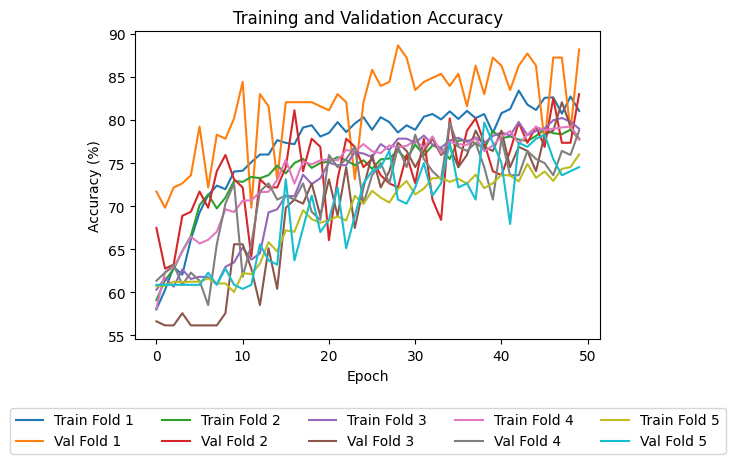

In [ ]:
figures= plt.figure(figsize=(6, 4))
plt.title('Training and Validation Accuracy')
for i in range(k_folds):
    plt.plot(training_accuracy[i], label=f'Train Fold {i+1}')
    plt.plot(val_accs[i], label=f'Val Fold {i+1}')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=k_folds)
plt.show()

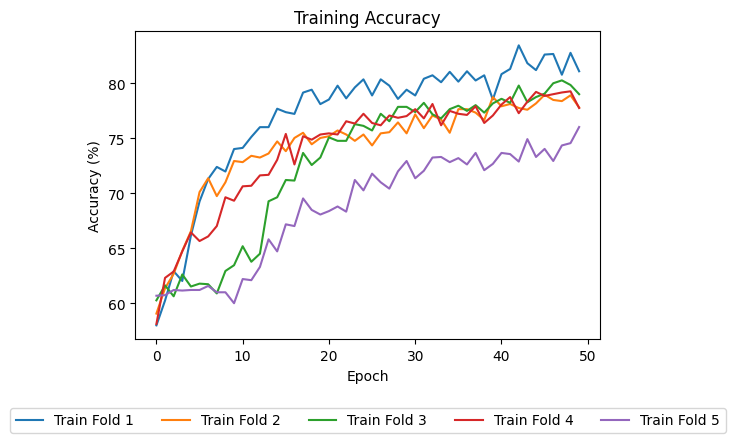

In [ ]:
figures = plt.figure(figsize=(6, 4))
plt.title('Training Accuracy')
for i in range(k_folds):
    plt.plot(training_accuracy[i], label=f'Train Fold {i+1}')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=k_folds)
plt.show()

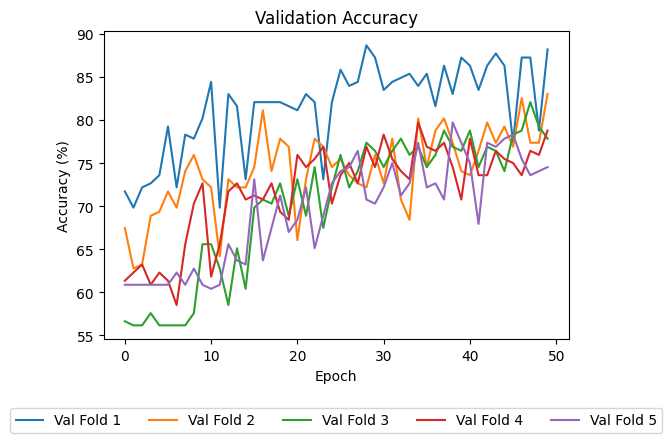

In [ ]:
figures = plt.figure(figsize=(6, 4))
plt.title('Validation Accuracy')
for i in range(k_folds):
    plt.plot(val_accs[i], label=f'Val Fold {i+1}')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=k_folds)
plt.show()

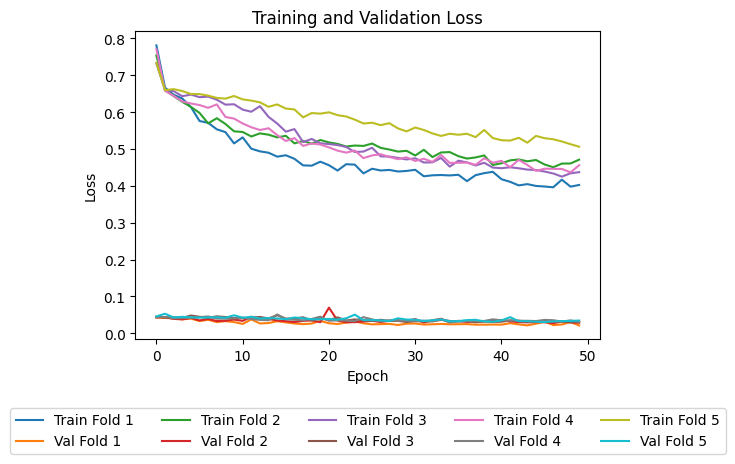

In [ ]:
figuree  = plt.figure(figsize=(6, 4))
plt.title('Training and Validation Loss')
for i in range(k_folds):
    plt.plot(train_losses[i], label=f'Train Fold {i+1}')
    plt.plot(val_losses[i], label=f'Val Fold {i+1}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=k_folds)
plt.show()

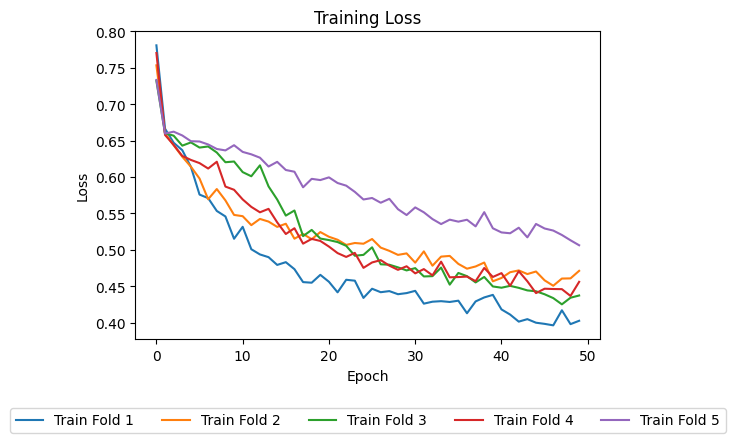

In [ ]:
figuree = plt.figure(figsize=(6, 4))
plt.title('Training Loss')
for i in range(k_folds):
    plt.plot(train_losses[i], label=f'Train Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=k_folds)
plt.show()

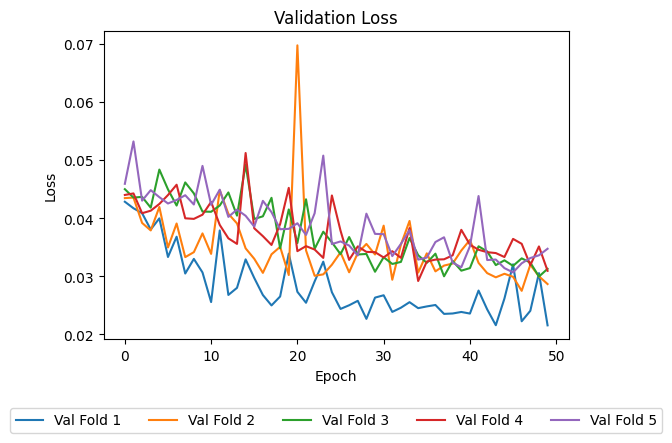

In [ ]:
figuree  = plt.figure(figsize=(6, 4))
plt.title('Validation Loss')
for i in range(k_folds):
    plt.plot(val_losses[i], label=f'Val Fold {i+1}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=k_folds)
plt.show()